In [172]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import nltk
import re



In [130]:
# Setup
sns.set(style="whitegrid")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santoshkumarguntupalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/santoshkumarguntupalli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [131]:
# Load dataset
dataset = load_dataset("TimKoornstra/financial-tweets-sentiment", trust_remote_code=True)
df = dataset['train'].to_pandas()

In [132]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet', 'sentiment', 'url'],
        num_rows: 38091
    })
})

In [133]:
df.sample(10)

,tweet,sentiment,url
7141,Azerbaijan's first snap parliamentary election...,0,https://huggingface.co/datasets/zeroshot/twitt...
23456,@RevShark @SharkInvesting Do you worry about t...,0,https://github.com/moritzwilksch/MasterThesis/...
12900,AAP > the 497 area will likely fail.,2,https://www.kaggle.com/datasets/yash612/stockm...
28981,If $TSLA gets under 200sma things will be ugly...,2,https://github.com/moritzwilksch/MasterThesis/...
19535,"Which tech stock you like most, Read our tho...",0,https://github.com/poojathakoor/twitter-stock-...
18830,long term\n,1,https://github.com/poojathakoor/twitter-stock-...
7222,Gove Rules Out Scottish Independence Referendu...,0,https://huggingface.co/datasets/zeroshot/twitt...
26840,Nice project @majornayor @StableGod @ciottii\n...,0,https://github.com/moritzwilksch/MasterThesis/...
25446,"""Let's make lots of money!"" \n$AMZN",1,https://github.com/moritzwilksch/MasterThesis/...
3173,$XLE: Sector Briefing: Energy https://t.co/FKD...,0,https://huggingface.co/datasets/zeroshot/twitt...


In [134]:
df.to_csv("financial_tweets.csv")

In [135]:
df["sentiment"].value_counts()

sentiment
1    17368
0    12181
2     8542
Name: count, dtype: int64

In [136]:
df.sample(10)['tweet'].values

array(['Welp, luck was on my side today, shot term short position on $MRNA when the news dropped. I will be eating well tonight',
       '$MU looks neat',
       '@airdropinspect This is a good &amp; promising project, their market work is very good, I hope the development of this project is getting BIG in the future.\n@contol_jogja\n \n@Zuki125320\n \n@tabah_rafli\n \n$MU #MuContinent #BSC #DeFi',
       'RECAP 11/22 Unusual Puts:\n$WMT Jan 120 P\n$BTU Feb 9 P\n$UBER Dec 28 P\n$GPS Mar 14 P\n$SPCE Dec 7.5 P\n$OLLI Dec 65 P… https://t.co/fgEcuNFyjC',
       "    did your Trade get Stopped Out because of The Market's  noises? we can help you to avoid it!\n",
       "$NVDA is going to close near $275 tomorrow. If you didn't buy calls today, you missed out. 🤷🏻\u200d♂️ 😘",
       'RT @justlisten_just: $EEENF 🚀🔥🔥 @AlexDelarge6553 @_RobertMichael_ https://t.co/kn89CLGI8U',
       '$EEENF 88 Energy has entered into a share subscription agreement (the "Subscription") with ELKO International LL

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38091 entries, 0 to 38090
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      38091 non-null  object
 1   sentiment  38091 non-null  int64 
 2   url        38091 non-null  object
dtypes: int64(1), object(2)
memory usage: 892.9+ KB


In [138]:
# Drop irrelevant or empty columns
df.drop(columns=["Unnamed: 0", "url"], errors='ignore', inplace=True)
df = df[~(df['tweet'].str.strip() == '')].reset_index(drop=True)

In [139]:
df.isnull().sum()

tweet        0
sentiment    0
dtype: int64

In [140]:
df.duplicated().sum()

0

In [143]:
# Pre-clean text function with improved regex and logic
important_stopwords = {
    'not', 'no', 'never', 'but', 'yet', 'however', 'because', 'since',
    'if', 'when', 'while', 'unless', 'until', 'still', 'despite', 'though'
}
stop_words = set(stopwords.words('english')) - important_stopwords
lemmatizer = WordNetLemmatizer()

In [144]:
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'http[s]?://\S+|httpst\.[a-zA-Z0-9]+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s!?.,]', '', text)
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return ' '.join(words)

# Apply cleaning
df['tweet'] = df['tweet'].apply(clean_text)


## EDA

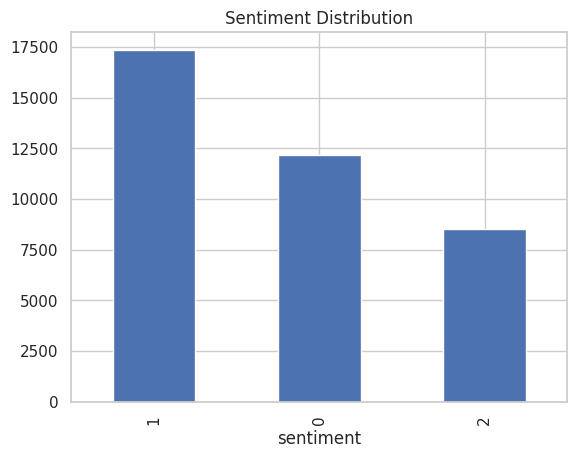

In [149]:
# Sentiment Distribution
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

In [150]:
# frequency distribution of sentiments

df['sentiment'].value_counts(normalize=True).mul(100).round(2)

sentiment
1    45.60
0    31.98
2    22.43
Name: proportion, dtype: float64

In [151]:
# Add word counts
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))
df['num_chars'] = df['tweet'].apply(len)
df['num_stop_words'] = df['tweet'].apply(lambda x: len([w for w in x.split() if w in stop_words]))
df['num_punctuation_chars'] = df['tweet'].apply(lambda x: sum(c in '.,!?;:"\'()[]{}-' for c in x))

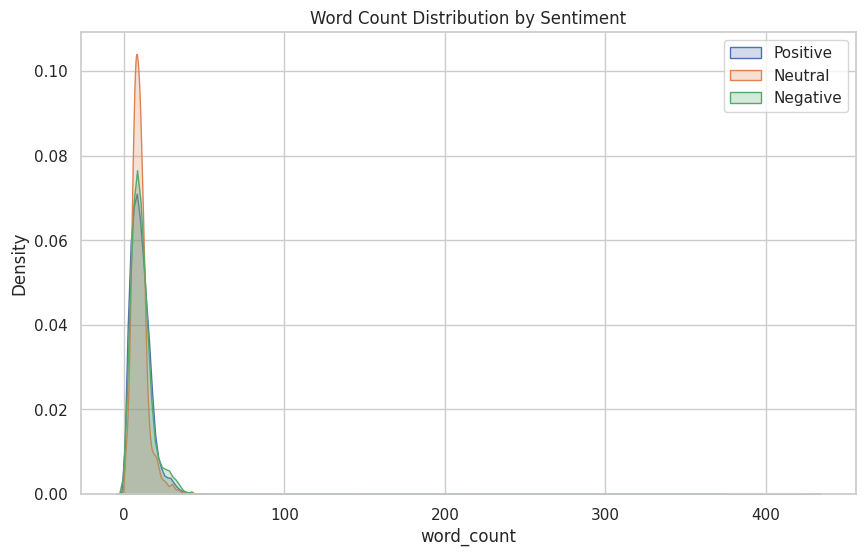

In [153]:
# Word count KDE
plt.figure(figsize=(10,6))
for label, name in zip([1, 0, 2], ['Positive', 'Neutral', 'Negative']):
    sns.kdeplot(df[df['sentiment']==label]['word_count'], label=name, fill=True)
plt.title("Word Count Distribution by Sentiment")
plt.legend()
plt.show()

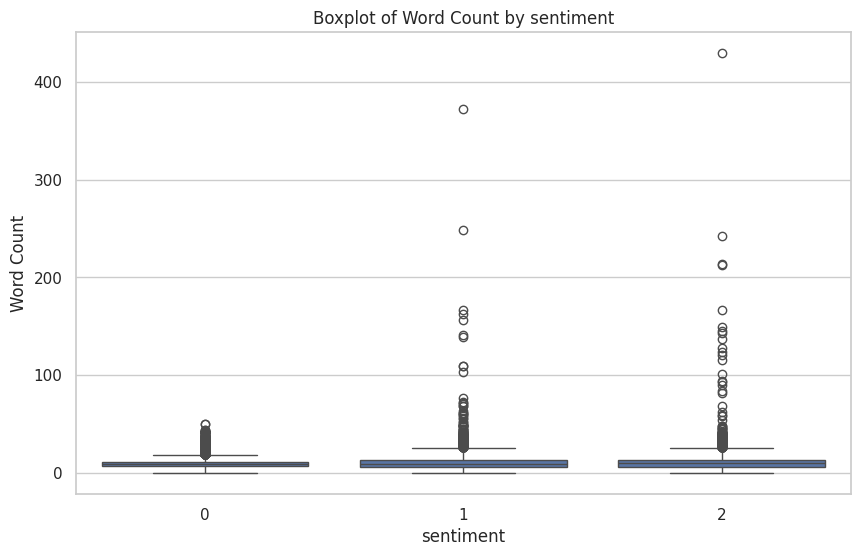

In [155]:
# Create a boxplot for the 'wordcount' column categorized by 'sentiment'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='word_count')
plt.title('Boxplot of Word Count by sentiment')
plt.xlabel('sentiment')
plt.ylabel('Word Count')
plt.show()

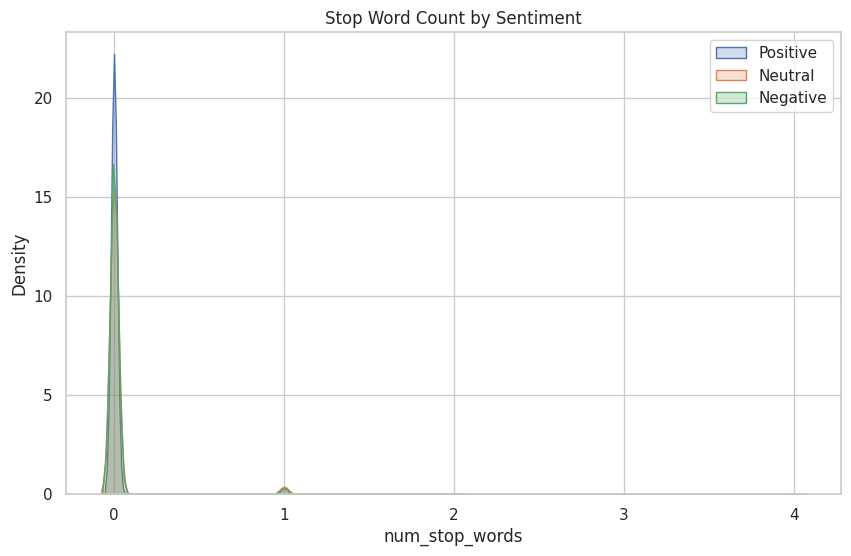

In [157]:
# Stopword Distribution KDE
plt.figure(figsize=(10,6))
for label, name in zip([1, 0, 2], ['Positive', 'Neutral', 'Negative']):
    sns.kdeplot(df[df['sentiment']==label]['num_stop_words'], label=name, fill=True)
plt.title("Stop Word Count by Sentiment")
plt.legend()
plt.show()

/tmp/ipykernel_347511/1800557199.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_stop_df, x='count', y='stop_word', palette='viridis')


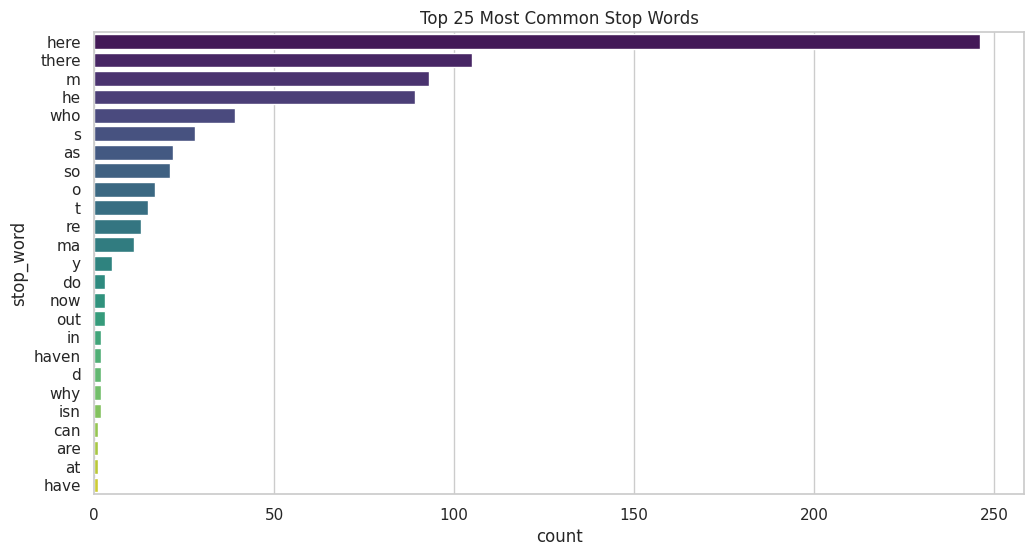

In [160]:

# Character frequency
char_freq = Counter(' '.join(df['tweet']))
char_freq_df = pd.DataFrame(char_freq.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

# Top 25 Stop Words
stopword_counter = Counter([w for tweet in df['tweet'] for w in tweet.split() if w in stop_words])
top_stop_df = pd.DataFrame(stopword_counter.most_common(25), columns=['stop_word', 'count'])

plt.figure(figsize=(12,6))
sns.barplot(data=top_stop_df, x='count', y='stop_word', palette='viridis')
plt.title("Top 25 Most Common Stop Words")
plt.show()

In [163]:
df

,tweet,sentiment,word_count,num_chars,num_stop_words,num_punctuation_chars
0,bynd jpmorgan reel expectation beyond meat,2,6,42,0,0
1,ccl rcl nomura point booking weakness carnival...,2,9,62,0,0
2,"cx cemex cut credit suisse, j.p. morgan weak b...",2,10,61,0,3
3,es btig research cut neutral,2,5,28,0,0
4,fnko funko slide piper jaffray pt cut,2,7,37,0,0
...,...,...,...,...,...,...
38085,facebook fb received buy rating well fargo 5st...,1,13,81,0,0
38086,tsla wish put back but see if find support aro...,2,15,73,0,2
38087,citrix system inc ctxs position increased mizu...,1,8,63,0,0
38088,notable gainer among liquid option name mornin...,1,18,98,0,10


/tmp/ipykernel_347511/680982939.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


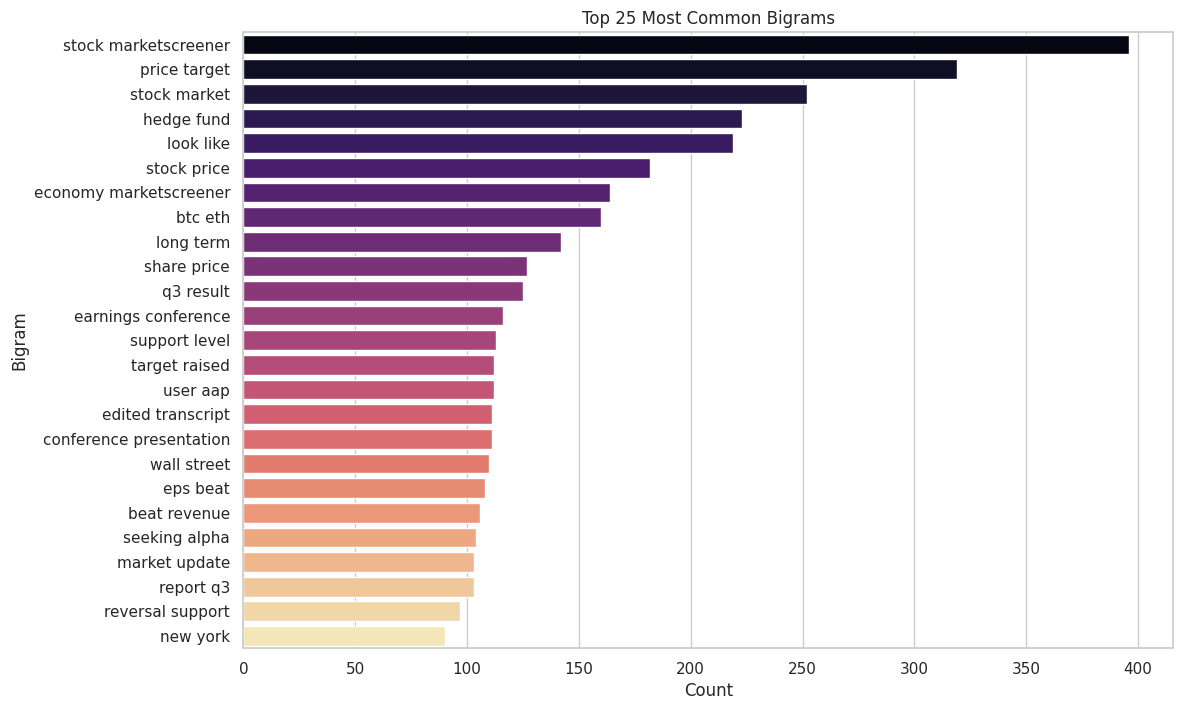

In [167]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a function to extract the top 25 bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 bigrams
top_25_bigrams = get_top_ngrams(df['tweet'], 25)

# Convert the bigrams into a DataFrame for plotting
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot the countplot for the top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()


/tmp/ipykernel_347511/2089151932.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')


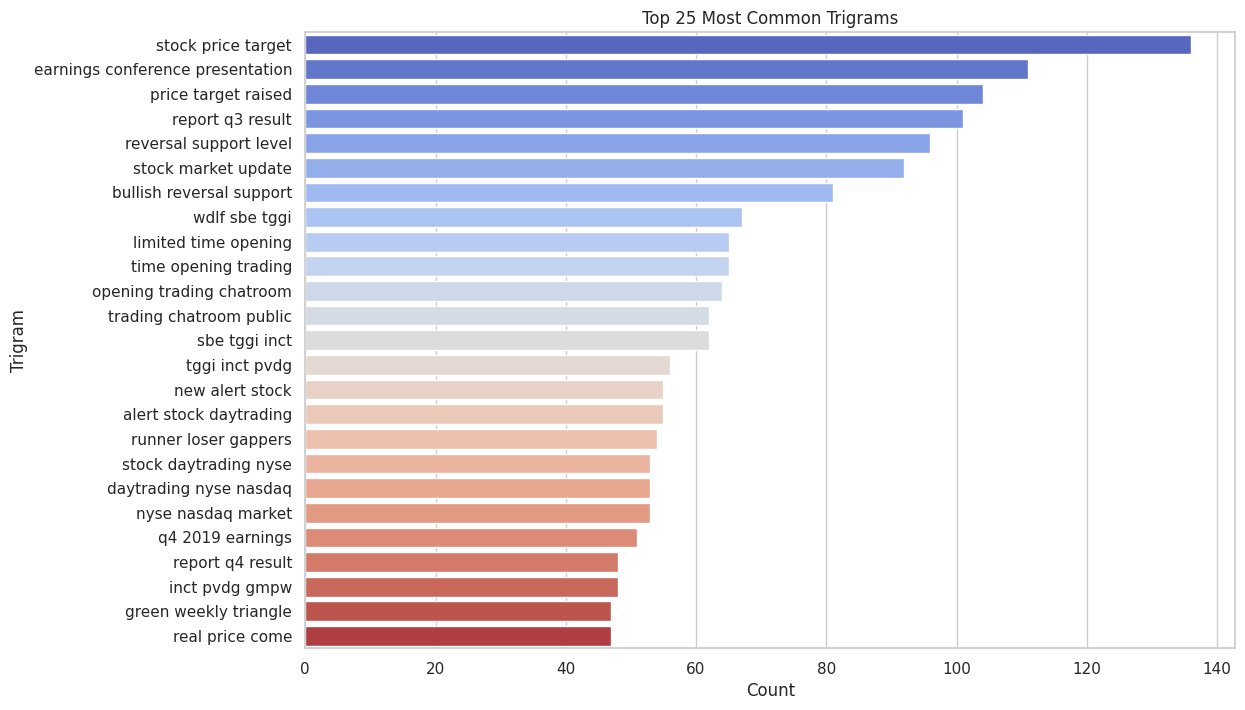

In [168]:
# Create a function to extract the top 25 trigrams
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 trigrams
top_25_trigrams = get_top_trigrams(df['tweet'], 25)

# Convert the trigrams into a DataFrame for plotting
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot the countplot for the top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

In [170]:
df.head()

,tweet,sentiment,word_count,num_chars,num_stop_words,num_punctuation_chars
0,bynd jpmorgan reel expectation beyond meat,2,6,42,0,0
1,ccl rcl nomura point booking weakness carnival...,2,9,62,0,0
2,"cx cemex cut credit suisse, j.p. morgan weak b...",2,10,61,0,3
3,es btig research cut neutral,2,5,28,0,0
4,fnko funko slide piper jaffray pt cut,2,7,37,0,0


In [171]:
def plot_word_cloud(text_series, title="Word Cloud"):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_series))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

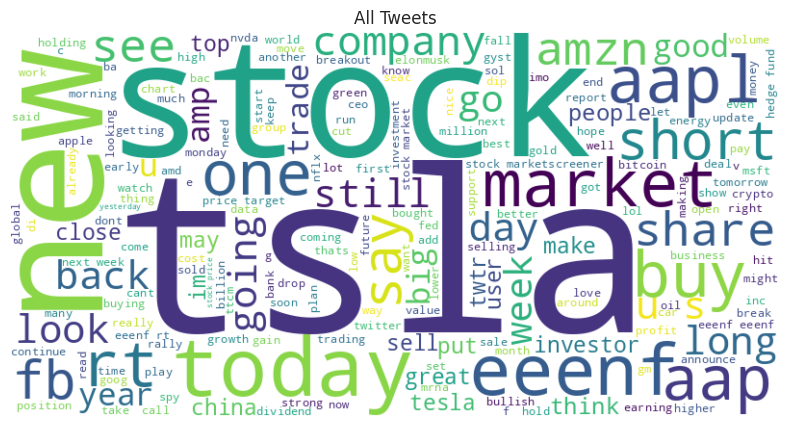

In [173]:
plot_word_cloud(df['tweet'], "All Tweets")

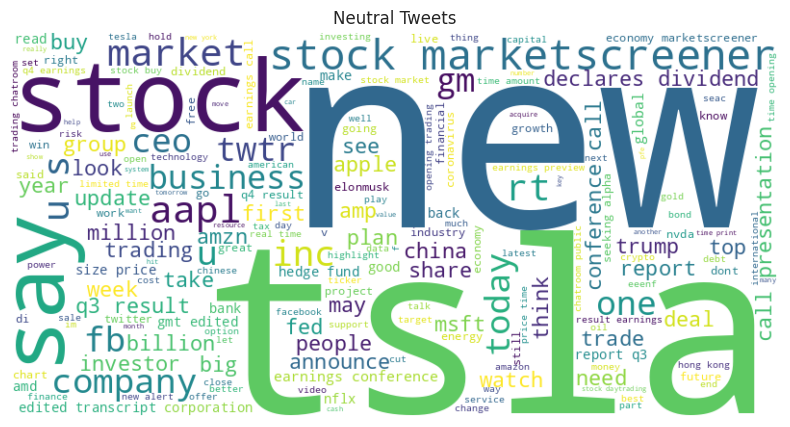

In [174]:
plot_word_cloud(df[df['sentiment'] == 0]['tweet'], "Neutral Tweets")

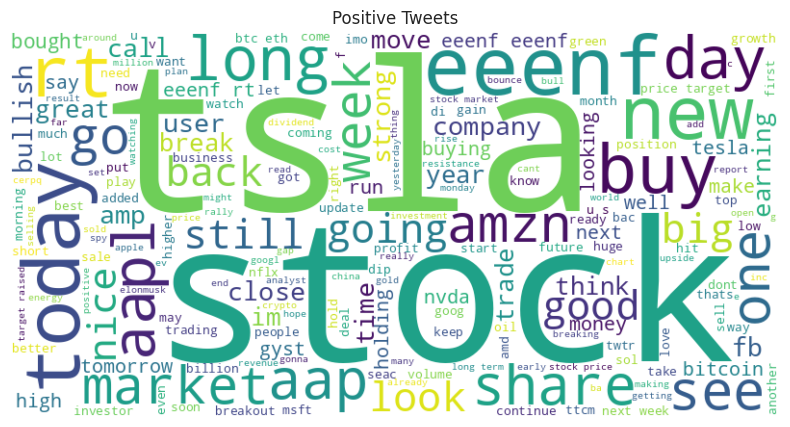

In [175]:
plot_word_cloud(df[df['sentiment'] == 1]['tweet'], "Positive Tweets")

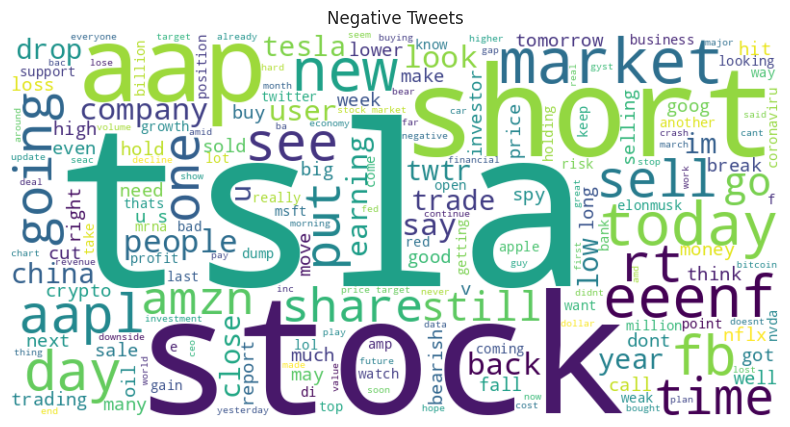

In [176]:
plot_word_cloud(df[df['sentiment'] == 2]['tweet'], "Negative Tweets")

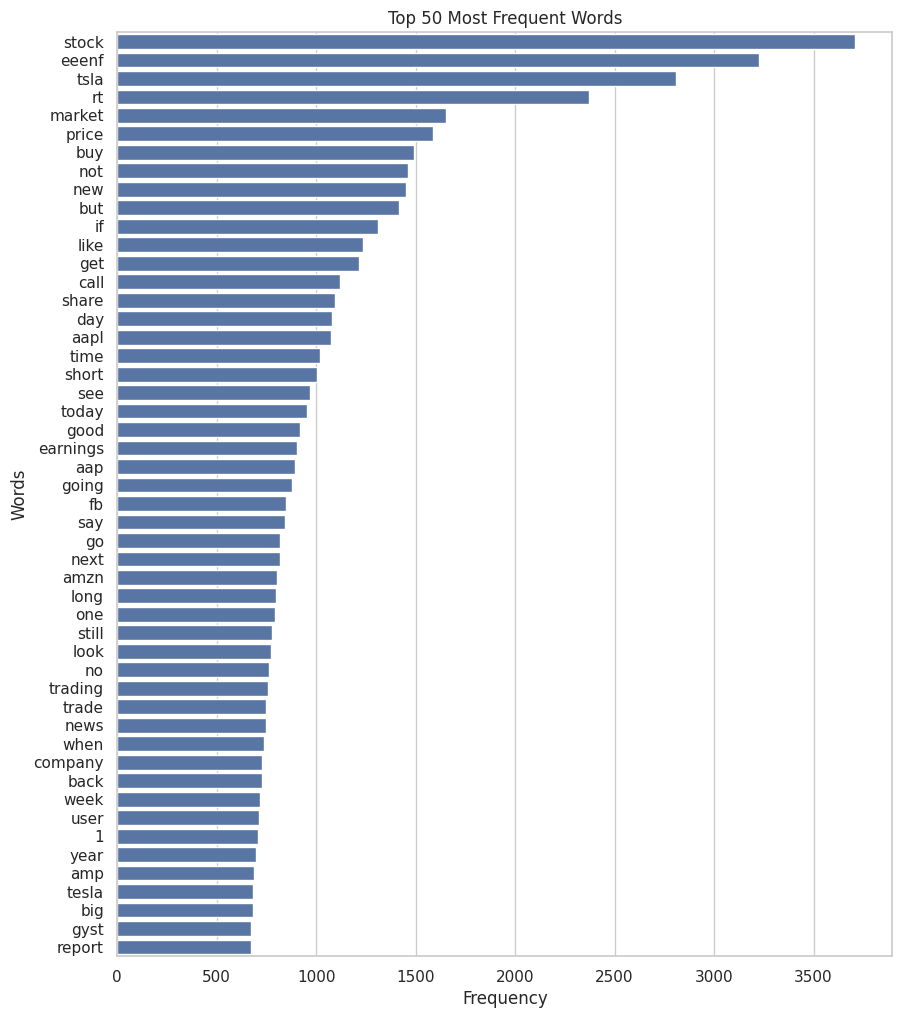

In [179]:
def plot_top_n_words(df, n=20):
    """Plot the top N most frequent words in the dataset."""
    # Flatten all words in the content column
    words = ' '.join(df['tweet']).split()

    # Get the top N most common words
    counter = Counter(words)
    most_common_words = counter.most_common(n)

    # Split the words and their counts for plotting
    words, counts = zip(*most_common_words)

    # Plot the top N words
    plt.figure(figsize=(10, 12))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top {n} Most Frequent Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Example usage
plot_top_n_words(df, n=50)


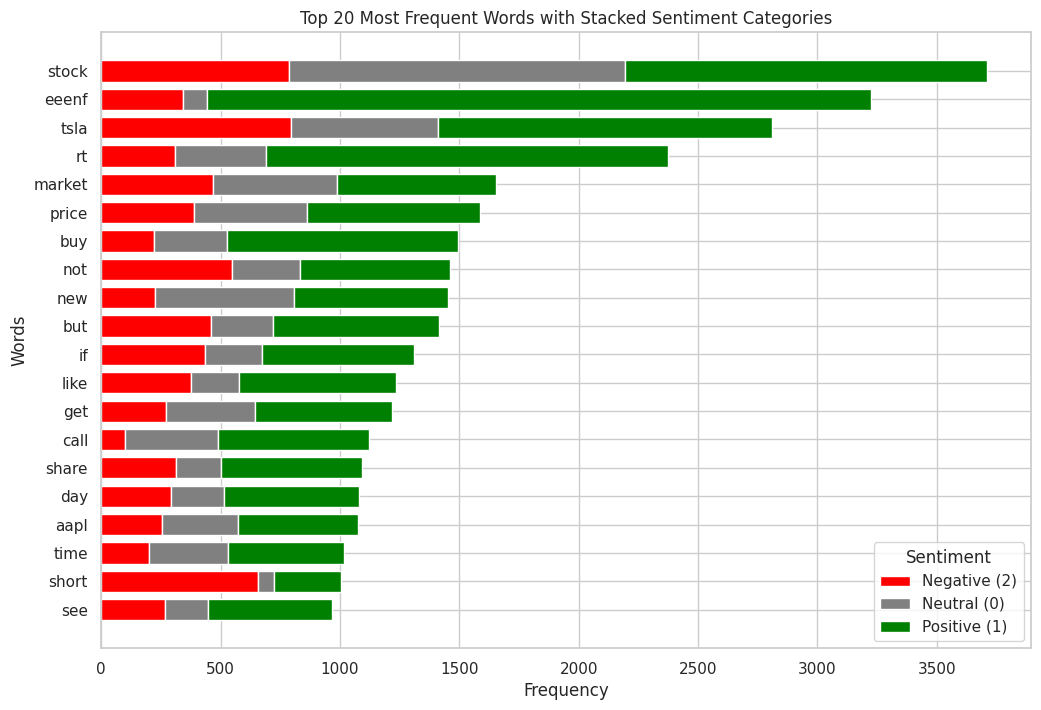

In [180]:
def plot_top_n_words_by_sentiment(df, n=20, start=0):
    """Plot the top N most frequent words in the dataset with stacked hue based on sentiment sentiment."""
    # Flatten all words in the content column and count their occurrences by sentiment
    word_sentiment_counts = {}

    for idx, row in df.iterrows():
        words = row['tweet'].split()
        sentiment = row['sentiment']  # Assuming 'sentiment' column exists for 0,1,2 labels

        for word in words:
            if word not in word_sentiment_counts:
                word_sentiment_counts[word] = { 0: 0, 1: 0, 2: 0 }  # Initialize counts for each sentiment sentiment

            # Increment the count for the corresponding sentiment sentiment
            word_sentiment_counts[word][sentiment] += 1

    # Get total counts across all categories for each word
    total_word_counts = {word: sum(counts.values()) for word, counts in word_sentiment_counts.items()}

    # Get the top N most frequent words across all categories
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
    top_words = [word for word, _ in most_common_words]

    # Prepare data for plotting
    word_labels = top_words
    negative_counts = [word_sentiment_counts[word][2] for word in top_words]
    neutral_counts = [word_sentiment_counts[word][0] for word in top_words]
    positive_counts = [word_sentiment_counts[word][1] for word in top_words]

    # Plot the stacked bar chart
    plt.figure(figsize=(12, 8))
    bar_width = 0.75

    # Plot negative, neutral, and positive counts in a stacked manner
    plt.barh(word_labels, negative_counts, color='red', label='Negative (2)', height=bar_width)
    plt.barh(word_labels, neutral_counts, left=negative_counts, color='gray', label='Neutral (0)', height=bar_width)
    plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], color='green', label='Positive (1)', height=bar_width)

    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Frequent Words with Stacked Sentiment Categories')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()



plot_top_n_words_by_sentiment(df, n=20)
